In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.projections.polar import PolarAxes
from pathlib import Path
import matplotlib.ticker as mtick

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.projections.polar import PolarAxes

def plot_radar(
    df: pd.DataFrame,
    label_col: str = None,
    value_cols: list[str] = None,
    normalize: bool = False,
    start_angle_deg: float = 90,
    clockwise: bool = True,
    colors: list[str] = None,
    line_width: float = 2.0,
    grid_color: str = "#9aa5b1",
    spine_color: str = "black",
    rgrid: list[float] = None,
    rmax: float = 0.4,
    r_major_step: float = 0.1,
    figsize=(20, 20),

    show_labels: bool = True,
    label_fontsize: int = 10,
    label_margin_px: int = 4,
    grid_linestyle: str = "--",
):
    if label_col is None:
        label_col = df.columns[0]
    if value_cols is None:
        value_cols = list(df.columns[1:])
    assert len(value_cols) >= 1, "At least one value column is required."

    labels = df[label_col].astype(str).tolist()
    values = df[value_cols].to_numpy(dtype=float)

    if normalize:
        vmin = values.min(axis=0, keepdims=True)
        vmax = values.max(axis=0, keepdims=True)
        denom = np.where((vmax - vmin) == 0, 1, (vmax - vmin))
        values = (values - vmin) / denom

    n = len(labels)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    angles_closed = np.concatenate([angles, angles[:1]])

    if colors is None:
        colors = ["#f38181", "#95e1d3", "#6c9bd2", "#f3c567", "#9b7ede"]

    fig = plt.figure(figsize=figsize)
    ax: PolarAxes = fig.add_subplot(111, polar=True)

    # Orientation settings
    ax.set_theta_direction(-1 if clockwise else 1)
    ax.set_theta_offset(np.deg2rad(start_angle_deg))
    ax.set_thetalim(0, 2*np.pi)

    # Radial axis range and ticks
    ax.set_ylim(0, rmax)
    try:
        ax.set_rmax(rmax)
    except Exception:
        pass

    if rgrid is None:
        rgrid = np.arange(r_major_step, rmax + 1e-9, r_major_step)
    ax.set_yticks(rgrid)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

    # Show every other label, and remove the outermost label (adjust as needed)
    # yticklabels = [f"{r:.2f}" if i % 2 == 1 else "" for i, r in enumerate(rgrid)]
    yticklabels = [f"{r:.2f}" for r in rgrid]  # Show all
    if len(yticklabels) > 0:
        yticklabels[-1] = ""
    ax.set_yticklabels(yticklabels, fontsize=20, fontweight='bold')

    # Style
    ax.spines["polar"].set_color(spine_color)
    ax.spines["polar"].set_linewidth(2.5)
    ax.grid(color=grid_color, linewidth=0.8, alpha=0.8, linestyle=grid_linestyle)

    ax.xaxis.grid(True, color=grid_color, linewidth=0.8, alpha=0.8, linestyle=grid_linestyle)
    ax.yaxis.grid(True, color=grid_color, linewidth=0.8, alpha=0.8, linestyle=grid_linestyle)

    # Angular ticks: do not attach text directly
    ax.set_xticks(angles)
    ax.set_xticklabels([""] * len(angles))

    # ====== Method names (toggleable) ======
    if show_labels:
        renderer = fig.canvas.get_renderer()

        def radial_dr_from_pixels(ax, ang, base_r, margin_px=4):
            # Convert pixel-level outward shift to Δr (data units)
            p1 = ax.transData.transform((ang, base_r))
            p2 = ax.transData.transform((ang, base_r + 1.0))
            px_per_unit = np.hypot(*(p2 - p1))
            return (margin_px / px_per_unit) if px_per_unit else 0.02

        for ang, name in zip(angles, labels):
            ang_deg = np.rad2deg(ang)
            # Display angle (considering start point and clockwise/counter-clockwise)
            disp_deg = (start_angle_deg - ang_deg) % 360 if clockwise else (start_angle_deg + ang_deg) % 360

            # Split into left/right hemispheres to avoid ha='center'
            if 315 <= disp_deg or disp_deg <= 45:
                ha = "left"
            elif 135 <= disp_deg <= 225:
                ha = "right"
            else:
                ha = "left" if (disp_deg < 180) else "right"

            # Base outward shift
            dr = radial_dr_from_pixels(ax, ang, rmax, margin_px=label_margin_px)

            # For ha='right' labels, project outward based on text width to prevent overlapping into the circle
            tmp_txt = ax.text(ang, rmax + dr, name, ha=ha, va="center",
                              rotation=0, rotation_mode="anchor",
                              fontsize=label_fontsize, visible=False)
            bbox = tmp_txt.get_window_extent(renderer=renderer)
            text_w_px = bbox.width
            tmp_txt.remove()

            radial_proj = abs(np.cos(np.deg2rad(disp_deg)))  # 0~1
            extra_px = text_w_px * radial_proj if ha == "right" else 0
            dr += radial_dr_from_pixels(ax, ang, rmax, margin_px=extra_px)

            label_r = rmax + dr
            ax.text(
                ang, label_r, name,
                ha=ha, va="center",
                rotation=0, rotation_mode="anchor",
                fontsize=label_fontsize,
            )

    # Polygon (hollow)
    for i, col in enumerate(value_cols):
        vals = values[:, i]
        vals_closed = np.concatenate([vals, vals[:1]])
        ax.plot(angles_closed, vals_closed, lw=line_width,
                color=colors[i % len(colors)], label=col, zorder=1)

    if len(value_cols) > 1:
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.10),
                  ncol=min(3, len(value_cols)), frameon=False, fontsize=11)

    plt.tight_layout()
    return fig, ax

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.projections.polar import PolarAxes

def plot_radar_two_dfs(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    label_col: str = None,
    value_cols: list[str] = None,
    normalize: bool = False,
    start_angle_deg: float = 90,
    clockwise: bool = True,
    color_list: list[str] = None,   # <<< Colors for two lines, length=2
    line_width: float = 2.0,
    grid_color: str = "#9aa5b1",
    spine_color: str = "black",
    rgrid: list[float] = None,
    rmax: float = 0.4,
    r_major_step: float = 0.1,
    figsize=(20, 20),
    show_labels: bool = True,
    label_fontsize: int = 10,
    label_margin_px: int = 4,
    grid_linestyle: str = "--",
    group_labels: tuple[str, str] = ("DF1", "DF2"),
    method_order: list[str] = None,
):
    """
    Plot metric comparisons of two DataFrames on the same radar chart:
    — Both lines are solid lines.
    — Use color_list = [color_df1, color_df2] to control colors.
    — value_cols represents multiple metrics; only one aggregate line (mean) is drawn for each df.
    """
    # Basic Checks
    if label_col is None:
        label_col = df1.columns[0]
    if value_cols is None:
        value_cols = list(df1.columns[1:])
    
    assert len(df1) == len(df2), "df1 and df2 must have the same number of rows (same labels)."
    assert list(df1[label_col]) == list(df2[label_col]), "The label order of both DataFrames must be consistent."
    assert len(color_list) == 2, "color_list must be a list of exactly 2 colors."

    # --------------- ⭐ New: Sort df1 and df2 by method_order ---------------
    if method_order is not None:
        # Check if all methods exist
        missing1 = set(method_order) - set(df1[label_col])
        missing2 = set(method_order) - set(df2[label_col])
        assert not missing1, f"df1 is missing the following methods: {missing1}"
        assert not missing2, f"df2 is missing the following methods: {missing2}"

        df1 = df1.set_index(label_col).loc[method_order].reset_index()
        df2 = df2.set_index(label_col).loc[method_order].reset_index()

    # Check label consistency again after sorting
    assert list(df1[label_col]) == list(df2[label_col]), "The label order of both DataFrames must be consistent."

    labels = df1[label_col].astype(str).tolist()
    n = len(labels)

    # Extract values
    vals1 = df1[value_cols].to_numpy(float)
    vals2 = df2[value_cols].to_numpy(float)

    # Multiple metric columns: take the mean for each df to draw one line 
    # (can be changed to other aggregation methods if needed)
    v1 = vals1.mean(axis=1)
    v2 = vals2.mean(axis=1)

    if normalize:
        allv = np.concatenate([v1, v2])
        vmin, vmax = allv.min(), allv.max()
        denom = vmax - vmin if vmax != vmin else 1
        v1 = (v1 - vmin) / denom
        v2 = (v2 - vmin) / denom

    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    angles_closed = np.concatenate([angles, angles[:1]])

    fig = plt.figure(figsize=figsize)
    ax: PolarAxes = fig.add_subplot(111, polar=True)

    # --- Orientation ---
    ax.set_theta_direction(-1 if clockwise else 1)
    ax.set_theta_offset(np.deg2rad(start_angle_deg))
    ax.set_thetalim(0, 2*np.pi)

    # --- Radius ---
    ax.set_ylim(0, rmax)
    try:
        ax.set_rmax(rmax)
    except Exception:
        pass

    if rgrid is None:
        rgrid = np.arange(r_major_step, rmax + 1e-9, r_major_step)
    ax.set_yticks(rgrid)
    yticklabels = [f"{r:.2f}" for r in rgrid]
    if len(yticklabels) > 0:
        yticklabels[-1] = ""
    
    # --- Style ---
    ax.spines["polar"].set_color(spine_color)
    ax.spines["polar"].set_linewidth(1)
    ax.grid(color=grid_color, linewidth=0.8, alpha=0.8, linestyle=grid_linestyle)

    ax.xaxis.grid(True, color=grid_color, linewidth=0.8, alpha=0.8, linestyle=grid_linestyle)
    ax.yaxis.grid(True, color=grid_color, linewidth=0.8, alpha=0.8, linestyle=grid_linestyle)

    # --- Hide angular ticks ---
    ax.set_xticks(angles)
    ax.set_xticklabels([""] * n)

    # --- Outer circle labels (consistent with original logic) ---
    if show_labels:
        renderer = fig.canvas.get_renderer()

        def radial_dr_from_pixels(ax, ang, base_r, margin_px=4):
            p1 = ax.transData.transform((ang, base_r))
            p2 = ax.transData.transform((ang, base_r + 1.0))
            px_per = np.hypot(*(p2 - p1))
            return (margin_px / px_per) if px_per else 0.02

        for ang, name in zip(angles, labels):
            ang_deg = np.rad2deg(ang)
            disp_deg = (start_angle_deg - ang_deg) % 360 if clockwise else (start_angle_deg + ang_deg) % 360

            # Left/Right hemispheres
            if 315 <= disp_deg or disp_deg <= 45:
                ha = "left"
            elif 135 <= disp_deg <= 225:
                ha = "right"
            else:
                ha = "left" if disp_deg < 180 else "right"

            # Estimate basic displacement first
            dr = radial_dr_from_pixels(ax, ang, rmax, margin_px=label_margin_px)

            # Add extra avoidance (original logic)
            tmp = ax.text(ang, rmax + dr, name, fontsize=label_fontsize,
                          ha=ha, va="center", visible=False)
            bbox = tmp.get_window_extent(renderer=renderer)
            text_w_px = bbox.width
            tmp.remove()

            radial_proj = abs(np.cos(np.deg2rad(disp_deg)))
            extra_px = text_w_px * radial_proj if ha == "right" else 0

            dr += radial_dr_from_pixels(ax, ang, rmax, margin_px=extra_px)
            ax.text(ang, rmax + dr + 0.5, name, ha=ha, va="center",
                    fontsize=label_fontsize)
    
    # ax.set_yticklabels(yticklabels, fontsize=10, fontweight="bold", zorder=10)
    # for label in ax.get_yticklabels():
    #     label.set_zorder(10)
    ax.set_yticklabels([])

    # ----------- Two "Average Metric Curves" -----------
    v1_closed = np.concatenate([v1, v1[:1]])
    v2_closed = np.concatenate([v2, v2[:1]])

    h1, = ax.plot(
        angles_closed, v1_closed,
        color=color_list[0],
        lw=line_width,
        linestyle="-",
        label=group_labels[0],
        zorder=3,
    )

    h2, = ax.plot(
        angles_closed, v2_closed,
        color=color_list[1],
        lw=line_width,
        linestyle="-",
        label=group_labels[1],
        zorder=2,
    )

    # ax.legend(
    #     loc="upper center",
    #     bbox_to_anchor=(0.5, 1.10),
    #     ncol=2,
    #     frameon=False,
    #     fontsize=12,
    #     handles=[h1, h2],
    # )

    plt.tight_layout()
    return fig, ax

In [15]:
method_rename_dict = {
        'velocyto': "Velocyto",
        'scvelo_dyn': "scVelo (dyn)",
        'scvelo_stc': "scVelo (stc)",
        'veloae': "VeloAE",
        'dynamo_m1': "Dynamo (m1)",
        'unitvelo_ind': "UniTVelo (ind)",
        'unitvelo_uni': "UniTVelo (uni)",
        'velovae_std': "VeloVAE (std)",
        'velovae_fullvb': "VeloVAE (Full VB)",
        'deepvelo': "DeepVelo",
        'celldancer': "cellDancer",
        'pyrovelocity_m1': "Pyro-Velocity (m1)",
        'pyrovelocity_m2': "Pyro-Velocity (m2)",
        'kvelo': "κ-velo",
        'velovi': "veloVI",
        'cell2fate': "cell2fate",
        'sdevelo': "SDEvelo",
        'svelvetvae': "SvelvetVAE",
        'latentvelo_std': "LatentVelo (std)",
        'tivelo_std': "TIVelo (std)",
        'tivelo_simple': "TIVelo (simple)",
        'sctour_mse': "scTour (MSE)",
        'sctour_nb': "scTour (NB)",
        'sctour_zinb': "scTour (ZINB)",
        'velvetvae': "VelvetVAE",
        'graphvelo_std': "GraphVelo (std)"
}

In [16]:
method_order = [
    "velocyto",
    "scvelo_dyn",
    "scvelo_stc",
    "veloae",
    "dynamo_m1",
    "pyrovelocity_m1",
    "pyrovelocity_m2",
    "unitvelo_uni",
    "unitvelo_ind",
    "velovae_std",
    "velovae_fullvb",
    "kvelo",
    "celldancer",
    "velovi",
    "latentvelo_std",
    "sctour_mse",
    "sctour_nb",
    "sctour_zinb",
    "deepvelo",
    "sdevelo",
    "svelvetvae",
    "cell2fate",
    "tivelo_std",
    "tivelo_simple",
    "graphvelo_std"
]

In [17]:
# aggregate scores

datasets = ['data11', 'data12', 'data13', 'data14', 'data15']

metric_name_1 = 'self_transition'
metric_name_2 = 'normalized_entropy'

## metric_1

In [18]:
all_scores = []

for dataset in datasets:
    df = pd.read_csv(Path(dataset) / f"{metric_name_1}_df.csv")
    
    df_mean = df.copy()
    df_mean["dataset_mean"] = df_mean.iloc[:, 1:].mean(axis=1)
    df_mean = df_mean[["Method", "dataset_mean"]]
    df_mean["dataset"] = dataset
    all_scores.append(df_mean)


concat_df = pd.concat(all_scores, ignore_index=True)

overall_mean = (
    concat_df.groupby("Method")["dataset_mean"]
    .mean()
    .reset_index()
    .rename(columns={"dataset_mean": "overall_mean"})
)

overall_rank_1 = overall_mean.copy()
overall_rank_1['rank'] = overall_rank_1['overall_mean'].rank(ascending=False)
overall_rank_1 = overall_rank_1[['Method', 'rank']]
overall_rank_1.to_csv("STS_rank.csv", index=False)

# overall_mean["Method"] = overall_mean["Method"].map(method_rename_dict)
overall_mean_1 = overall_mean.copy()

## metric_2

In [19]:
all_scores = []

for dataset in datasets:
    df = pd.read_csv(Path(dataset) / f"{metric_name_2}_df.csv")
    
    df_mean = df.copy()
    df_mean["dataset_mean"] = df_mean.iloc[:, 1:].mean(axis=1)
    df_mean = df_mean[["Method", "dataset_mean"]]
    df_mean["dataset"] = dataset
    all_scores.append(df_mean)

concat_df = pd.concat(all_scores, ignore_index=True)

overall_mean = (
    concat_df.groupby("Method")["dataset_mean"]
    .mean()
    .reset_index()
    .rename(columns={"dataset_mean": "overall_mean"})
)

overall_rank_2 = overall_mean.copy()
overall_rank_2['rank'] = overall_rank_2['overall_mean'].rank(ascending=False)
overall_rank_2 = overall_rank_2[['Method', 'rank']]
overall_rank_2.to_csv("NTE_rank.csv", index=False)
# overall_mean["Method"] = overall_mean["Method"].map(method_rename_dict)
overall_mean_2 = overall_mean.copy()

In [20]:
color_lst = ["#fc5185", "#364f6b"]

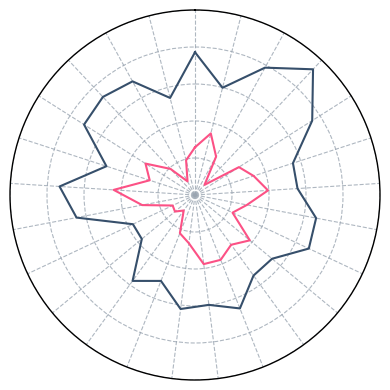

In [21]:
fig, ax = plot_radar_two_dfs(df1=overall_mean_1, 
                     df2=overall_mean_2,
                     method_order=method_order,
                     label_col="Method",
                     value_cols=["overall_mean"],
                     figsize=(4, 4),
                     rgrid = np.linspace(0, 0.9, 6)[1:],
                     line_width=1.5,
                     show_labels=False,
                     color_list=color_lst)

In [22]:
fig.savefig("radar_plot_negative_control.svg", dpi=300)

In [26]:
# fig, ax = plot_radar(overall_mean, 
#                      figsize=(8, 8),
#                      rgrid = np.linspace(0, 0.42, 6)[1:],
#                      line_width=4.0,
#                      show_labels=False,
#                      colors=["#fc5185"])

In [27]:
# fig, ax = plot_radar(overall_mean, 
#                      figsize=(8, 8),
#                      rgrid = np.linspace(0, 0.9, 6)[1:],
#                      line_width=4.0,
#                      show_labels=False,
#                      colors=["#364f6b"])